In [95]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from loguru import logger
from tqdm import tqdm
import numpy as np
from utils.utils_embedding import evaluate, dataframe_results, plot_embeddings
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Settings

In [91]:
# load dataset QA
dataset_name = "QA/gpt-35-turbo_dataset.json"
# results top-k
top_k = 5

# load dataset

In [92]:
it_dataset = EmbeddingQAFinetuneDataset.from_json(dataset_name)

keys_to_delete = [key for key in it_dataset.corpus.keys() if it_dataset.corpus[key] == '']
for key in keys_to_delete:
    del it_dataset.corpus[key]

# View sample QA dataset

In [93]:
print(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.relevant_docs["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

Qual è la data del documento di lavoro dei servizi della Commissione Europea sulla relazione per paese 2025 dell'Italia?
['80b9998c-32d4-42f7-94a7-1a36155b382b']
IT   IT 
 
 
 COMMISSIONE  
EUROPEA   
Bruxelles, 4.6.2025  
SWD(2025) 212 final  
 
DOCUMENTO DI LAVORO DEI SERVIZI DELLA COMMISSIONE  
Relazione per paese 2025 - Italia  
che accompagna il documento  
Raccomandazione di RACCOMANDAZIONE DEL CONSIGLIO  
sulle politiche economiche, sociali, occupazionali, strutturali e di bilancio dell'Italia  
{COM(2025)  212 final}


# HuggingFace: paraphrase-multilingual-MiniLM-L12-v2

In [90]:
embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


# Validation


In [94]:
df_paraphrase_l12_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=embed_model_paraphrase_l12, 
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_paraphrase_l12_results_it))
df_paraphrase_l12_results_it.head()

100%|██████████| 260/260 [00:03<00:00, 77.67it/s]

260


,is_hit,mrr,retrieved,expected,query
0,True,1.0,"[80b9998c-32d4-42f7-94a7-1a36155b382b, ca82b43...",80b9998c-32d4-42f7-94a7-1a36155b382b,6c67a361-1d84-4876-8ed5-72e11dd2f21e
1,False,0.0,"[e81fb935-4ea8-4a80-867d-ed15f40d0a0c, 0ddb84a...",93b772d4-52a6-44a6-a331-0eae1fdf33a5,5377179f-f310-4498-9a81-4a644d21eef6
2,True,1.0,"[f612986a-0b1a-4c12-bdf1-2c2107733db7, f1b6e8e...",f612986a-0b1a-4c12-bdf1-2c2107733db7,a980095d-5cd4-4112-9b80-d3d1e7023f44
3,True,1.0,"[b87e8ec1-9380-48ad-9428-47c47ede0e76, c0f6569...",b87e8ec1-9380-48ad-9428-47c47ede0e76,364684a1-eafa-4081-ba35-bb669d1657b7
4,True,0.5,"[e96386a3-3796-457d-875e-2d6c7bdab02f, 4a5026b...",4a5026bd-2856-497f-8276-9de39b7562e6,2356fbfa-7df2-467d-ac72-ef26ed474fff


In [ ]:
set_embeddings = []
for id_, text in tqdm(it_dataset.corpus.items()):
    embedding = embed_model_paraphrase_l12.get_text_embedding(text)
    set_embeddings.append(embedding)
array_embeddings = np.array(set_embeddings)

100%|██████████| 258/258 [00:03<00:00, 71.20it/s]


# perform PCA

In [ ]:
pca = PCA(n_components=2)
projected = pca.fit_transform(array_embeddings)

# retrieve with expected not in top-k

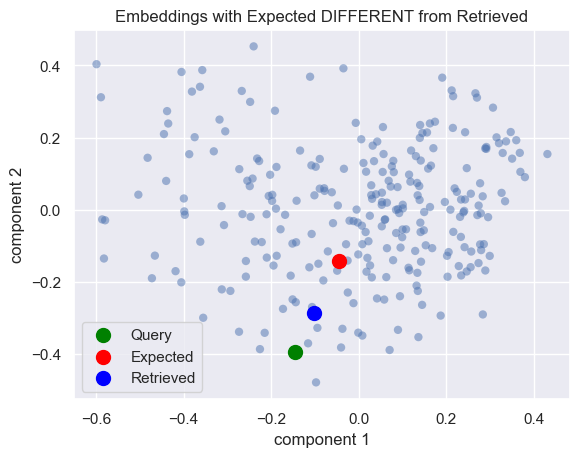

In [ ]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["5377179f-f310-4498-9a81-4a644d21eef6"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["93b772d4-52a6-44a6-a331-0eae1fdf33a5"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["e81fb935-4ea8-4a80-867d-ed15f40d0a0c"])

plot_embeddings(pca, projected, query_embedding, expected_embedding, retrieved_embedding)

# retrieve with expect in top-k

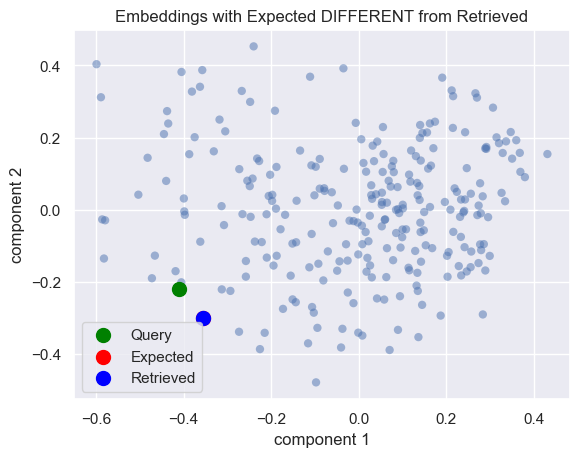

In [ ]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

plot_embeddings(pca, projected, query_embedding, expected_embedding, retrieved_embedding)

In [ ]:
df_results_no_finetuning = dataframe_results(top_k, df_paraphrase_l12_results_it)
df_results_no_finetuning

,model,top_k,mrr,is_hit
0,paraphrase-multilingual-MiniLM-L12-v2,5,0.530641,0.653846
